In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(42)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

using device: cuda


In [4]:
df = pd.read_csv("/content/sample_data/fashion-mnist_train.csv")
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,0,0,0,0,0,0,0,5,0,...,0.0,0.0,0.0,30.0,43.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,1,2,0,0,0,0,...,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,3,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df.shape

(15150, 785)

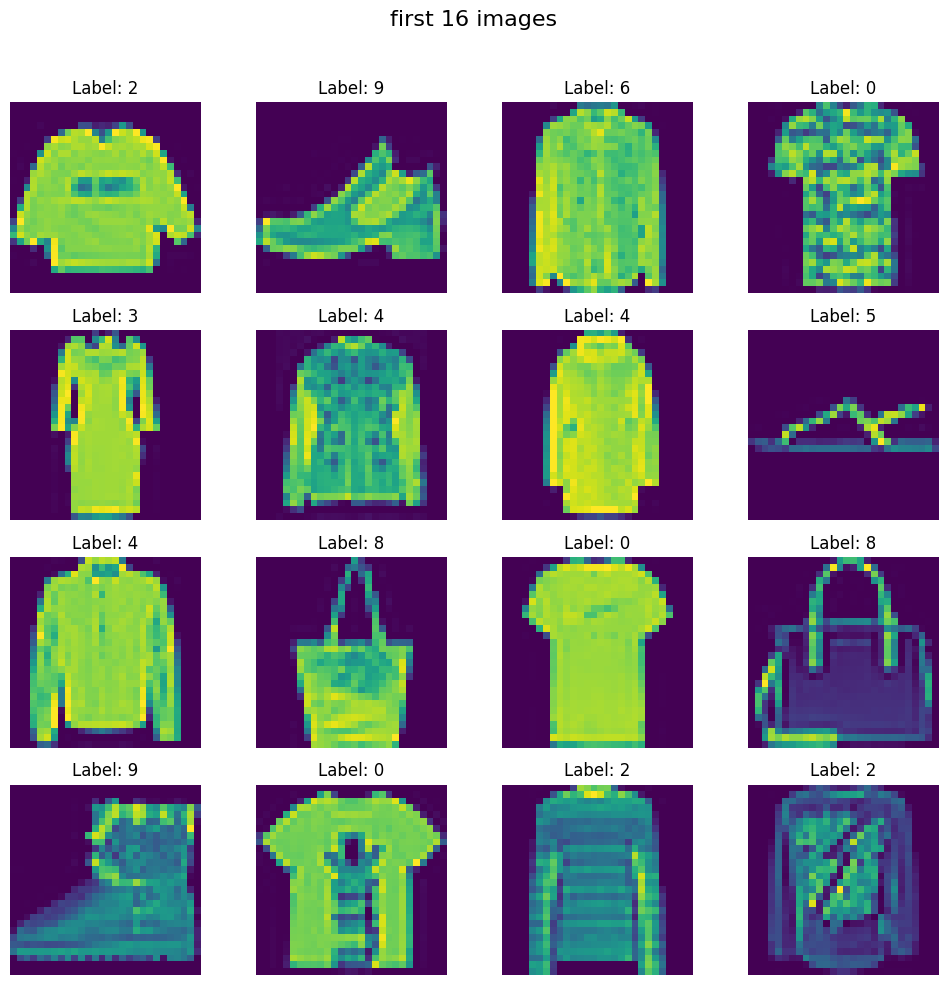

In [10]:
fig, axes = plt.subplots(4,4, figsize=(10,10))
fig.suptitle("first 16 images", fontsize=16)

for i, ax in enumerate(axes.flat):
  img = df.iloc[i, 1:].values.reshape(28,28)
  ax.imshow(img)
  ax.axis("off")
  ax.set_title(f"Label: {df.iloc[i,0]}")

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


In [11]:
#train test spilt

X = df.iloc[:,1:].values
y = df.iloc[:,0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
X

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., nan, nan, nan]])

In [13]:
y

array([2, 9, 6, ..., 2, 4, 5])

In [15]:
from torchvision.transforms import transforms

custome_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [16]:
from PIL import Image
import numpy as np

In [17]:
class customDataset(Dataset):

  def __init__(self, features, labels, transform):
    self.features = features
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):

    # resize to (28, 28)
    image = self.features[index].reshape(28,28)


    # change datatypes to np.unit8
    image = image.astype(np.uint8)


    # change black and white to color
    image = np.stack((image,)*3, axis=-1)

    # convert to PIL image
    image = Image.fromarray(image)

    # apply transforms
    image = self.transform(image)

    # return
    return image, torch.tensor(self.labels[index], dtype=torch.long)


In [19]:
train_dataset = customDataset(X_train, y_train, transform=custome_transform)
test_dataset = customDataset(X_test, y_test, transform=custome_transform)

In [20]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [21]:
import torchvision.models as models

vgg16 = models.vgg16(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:09<00:00, 59.4MB/s]


In [22]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [23]:
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [24]:
for param in vgg16.parameters():
  param.requires_grad = False

In [25]:
vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 10)
)

In [26]:
vgg16 = vgg16.to(device)

In [27]:
learning_rate = 0.0001
num_epochs = 10

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=learning_rate)

In [31]:
# training loop

for epoch in range(num_epochs):

  total_epochs_loss = 0

  for batch_features, batch_labels in train_loader:

    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    outputs = vgg16(batch_features)

    loss = criterion(outputs, batch_labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_epochs_loss += loss.item()


  print(f"Epoch: {epoch+1}, Loss: {total_epochs_loss/len(train_loader)}")


/tmp/ipython-input-3918095429.py:18: RuntimeWarning: invalid value encountered in cast
  image = image.astype(np.uint8)


Epoch: 1, Loss: 0.5479002531450783
Epoch: 2, Loss: 0.27438182716004766
Epoch: 3, Loss: 0.19007352074131487
Epoch: 4, Loss: 0.1399978036355807
Epoch: 5, Loss: 0.09163982591943172
Epoch: 6, Loss: 0.07124579724263508
Epoch: 7, Loss: 0.05603510950075212
Epoch: 8, Loss: 0.038437267385901135
Epoch: 9, Loss: 0.030834639602752973
Epoch: 10, Loss: 0.0321472771805963


In [35]:
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [36]:
with torch.no_grad():
  correct = 0
  total = 0
  for batch_features, batch_labels in test_loader:
    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)
    outputs = vgg16(batch_features)
    _, predicted = torch.max(outputs.data, 1)
    total += batch_labels.size(0)
    correct += (predicted == batch_labels).sum().item()

  print(f"Accuracy of the model on the {total} test images: {100 * correct / total} %")

Accuracy of the model on the 3030 test images: 89.96699669966996 %
